# `III. Multipole Expansion` 
This .pynb file reads `./inter_results/field_result.pkl` generated by `./II_Field_Simulation.ipynb`, and analyzes the field distribution result. This analysis can be specific according to your own need. Here, as an example, we focus on multipole expansion coefficient. 

## (1) import electric field and set parameters for it.

In [199]:
import sys
sys.path.append('../../')
import scipy.ndimage as im
import pickle
# add multipoles package path
import pandas as pd
from utils.multipoles import MultipoleControl
from utils.plottingfuncns import *

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from collections import OrderedDict
module_path = os.path.abspath('')
from utils.helper_functions import *

## Import Simulated Data

In [237]:
###### loading in pickle file ###############################
# import data, and define parameters
module_path = os.path.abspath('')

radius= 500e-3
area = 1e-4
path = module_path+'/inter_results/htrap/htrap_el3_'+str(radius)+'_'+str(area)+'_simulation.pkl'
# path = module_path+'/inter_results/htrap/charge_mit_charge_0.1_5e-06_simulation.pkl'
# path = module_path+'/inter_results/htrap/simple_roughness_1.0_2e-06_simulation.pkl'


# file_out = 'htrap_overhang_taper_el3'
# path = module_path+'/inter_results/taper_overhang/'+file_out+'_'+str(radius)+'_'+str(area)+'_simulation_tall_rough.pkl'

print(str(area))
# file_out = 'htrap_el4'
# path = module_path+'/inter_results/htrap/'+file_out+'_'+str(radius)+'_'+str(area)+'_simulation.pkl'


f = open(path, 'rb')
trap = pickle.load(f)
# trap['X'], trap['Y'], trap['Z'] are the position coordinates for the simulated volume
print("x positions of the simulation")
print(trap['Z'])
#trap['electrodes'] is a dictionary with keys that correspond to each electrode
print("electrodes simulated")
print(trap['electrodes'].keys())
#plugging in one of the keys, in this case 'DC1,' gives access to the 3-dimensional 
#simulated potentials for that electrode while 'position' is just a refeerence location
# for easy plotting using matplotlib that can be set anytime.  
print("shape of the simulated potential voltages for DC1")
# print(np.shape(trap['electrodes']['DC1']['potential']))
# print(trap['electrodes']['DC1']['position'])
#the 'potential' for 'RF' is really the |E|^2, which can be used to generate the pseudopotential
#note that the units are V/mm^2- all the units in these files are mm b/c that's what fusion360 exports,
#that coordinate system is continued just for consistency. 
print("shape of the simulated |E|^2 for RF")
print(np.shape(trap['electrodes']['RF']['potential']))

#############################################################

0.0001
x positions of the simulation
[-0.275 -0.274 -0.273 -0.272 -0.271 -0.27  -0.269 -0.268 -0.267 -0.266
 -0.265]
electrodes simulated
dict_keys(['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21', 'RF'])
shape of the simulated potential voltages for DC1
shape of the simulated |E|^2 for RF
(11, 11, 11)


In [238]:

###### setting up multipole expansion @ trap location #######
#xl, yl, zl define the origin at which we will do the multipole expansion
#i.e. they define where you want to trap

#strs are the string names of your DC electrodes (copy from loading pickle,
#I wrote it a second time so that the code runs in case you comment out that code)

strs = list(trap['electrodes'].keys())
zl = -270*1e-3
xl = 3.75*1e-3
yl = 75*1e-3

position = [xl, yl, zl]

#ROI = 'range of interest', I believe
#It defines the volume region over which multipole expansion will be performed.
#nROI is the number of points that make up the dimensions of the volume of the ROI
#I believe it ends up being the indices of the 3-d array that you index so it is dimensionless
nROI = 3
roi = [nROI, nROI, nROI]
order = 3

#controlled electrodes- this will define which electrodes will be used to control your trap
controlled_electrodes = []

## (2) set parameters for multipole expansion
notes:
* new from shuqi's code- 'excl' defines a dictionary of excluded electrodes the dictionary index (left of colon)  is the electrode you want to exclude its value (right of colon) defines what you want to set it to if you set it to "gnd" it will always set the voltage of that DC to 0 if you set it to "DCx" it will always set the voltage of that DC to be the same as DCx this is in case you have trap shorts, if you don't need it just don't include the indices

In [239]:
# excl = {
#     "DC9":"gnd",
#     "DC11":"gnd",
#     "RF":"gnd",
#     "DC0":"gnd"
#     "DC2":"DC3"

# }
excl = {"RF":"gnd"}

#build the controlled electrodes list, given the constraints of the 'excl' list
for electrode in strs:
    if electrode in excl and excl[electrode] != "gnd":
        trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                           trap['electrodes'][electrode]["potential"]
    elif electrode not in excl:
        controlled_electrodes.append(electrode)

#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
print(np.shape(trap['electrodes'][electrode]["potential"]))

# create MultipoleControl object
s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)
s.electrode_positions = OrderedDict([('DC1', [0, 1]), ('DC2', [0, 2]), ('DC3', [0, 3]), ('DC4', [0, 4]), 
             ('DC5', [0, 5]), ('DC6', [0, 6]), ('DC7', [0, 7]), ('DC8', [0, 8]), 
             ('DC9', [0, 9]), ('DC10', [0, 10]), ('DC11', [2, 1]), ('DC12', [2, 2]), 
             ('DC13', [2, 3]), ('DC14', [2, 4]), ('DC15', [2, 5]),('DC16', [2, 6]),
             ('DC17', [2, 7]),('DC18', [2, 8]),('DC19', [2, 9]),('DC20', [2, 10]),
             ('DC21', [1, 1]),('RF', [1, 2])])
print(controlled_electrodes)

#     return s
# s,used_multipoles = generate_s(excl)
###############################################################

(11, 11, 11)
['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21']


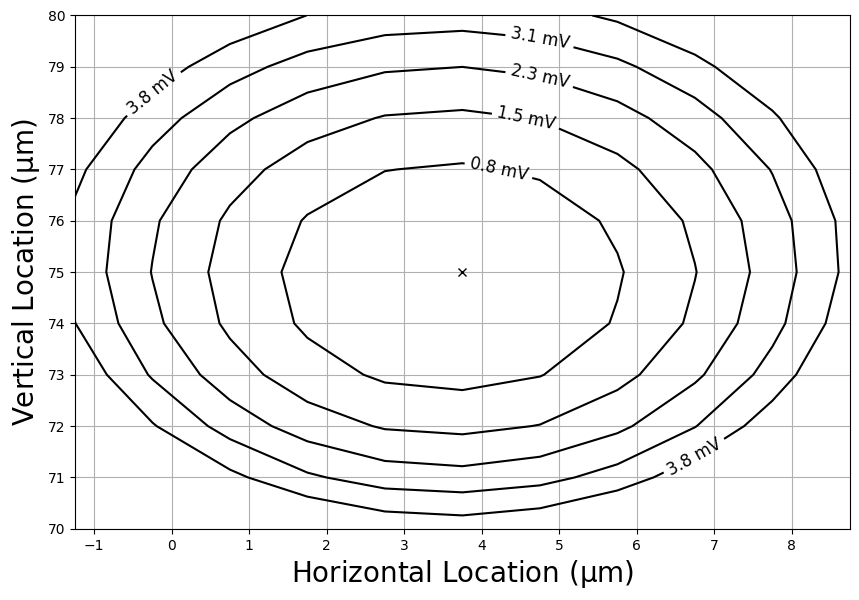

In [ ]:
# Generating pseudopotential
##############################################################################################################################
#q = ion charge
#l = units of used to specify simulation grid, should likely be 1 mm
#Omega = trap drive angular frequency
#voltage = RF voltage
#v_to_mV = convert pseudopotential units from volts to millivolts
q = 1.6*1e-19
l = 1e-3
m = 40*1.66054e-27
Omega = 2*np.pi*39.15*1e6
voltage = 80
v_to_mV = 1000 
# voltage = 50*1.26 for taper trap based on lower radial x  (2.08MHz @ 1.5dbm R&S, ~1.4 W transmitted power)

#generating pseudopotential from simulated |E|^2 of RF field
d = trap['electrodes']['RF']['potential'][:,:,0]*voltage**2*q/(4*m*Omega**2)/l**2*v_to_mV
##############################################################################################################################

# taper trap stuff
##############################################################################################################################
# for taper trap: u2 solution that can be superimposed onto the RF
# u2_soln =\
# [0.322124,0.245919,-2.669645,0.243209,-0.296533,-0.256699,-0.212897,-0.172587,
# -0.136261,-0.111947,-0.260888,-0.391296,-2.656598,-0.378270,-0.208301,-0.181067
# ,-0.149683,-0.115415,-0.089443,-0.072666,-0.374573]
# pot_array = np.zeros(np.shape(trap['electrodes']['RF']['potential'][:,:,0]))
# for i in np.arange(1,21,1):
#     pot_array = pot_array+trap['electrodes']['DC'+str(i)]['potential'][:,:,0]*u2_soln[i]*20
# d = d+pot_array
##############################################################################################################################

# Generate contour plot
##############################################################################################################################
#generate figure to plot RF fields
plt.figure(figsize=(30/3,20/3))

#numInter = number of points used to interpolate between points
#CAUTION: no idea what the interpolation function looks like, so be wary of using the 
# interpolated for quantitative calculations or multipoe decomposition. I only use it
# so I can smooth out out the field to get a basic idea of what the RF looks like when 
# I'm not using many gridpoints in the simulation
# num_inter = 5
# d = im.zoom(d, num_inter)
# x = im.zoom(trap['X'],num_inter)*1e3
# y = im.zoom(trap['Y'],num_inter)*1e3


#d is RF pseudopotential field 
#x , y are the x, y axes
d = d
x = trap['X']*1e3
y = trap['Y']*1e3


#setting contour values
min_val = np.min(d)
max_val =  np.max(d)*0.5
steps = 5
c_range = np.arange(min_val,max_val,(max_val-min_val)/(steps+1))

#plotting contours
cmap = LinearSegmentedColormap.from_list('black', ['black', 'black'])
CS = plt.contour(x,y,np.transpose(d),levels=c_range,cmap=cmap,zorder=2)

#labeling contours
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} mV" if plt.rcParams["text.usetex"] else f"{s} mV"
plt.clabel(CS, CS.levels, inline=True,fmt=fmt,fontsize=12,use_clabeltext=True)
##############################################################################################################################


# Find location of the RF null
##############################################################################################################################
min_value = np.min(d[:,:])
coordinates = np.where(d == min_value)
plt.plot(x[coordinates[0][0]],y[coordinates[1][0]],'kx')
xval = int(np.round(x[coordinates[0]],0)[0])
yval = int(np.round(y[coordinates[1]],0)[0])
##############################################################################################################################


# Saddle Finding (only works if simulation goes to 150-160um away from the trap)
##############################################################################################################################
# def find_saddle(V,X,Y):
#     """Returns the indices of the local extremum or saddle point of the scalar A as (Is,Js,Ks).
#     V is a 3D matrix containing an electric potential and must solve Laplace's equation
#     X,Y,Z are the vectors that define the grid in three directions
#     Z0: Z coordinate for saddle finding in a 2D potential slice
#     For dim==2, the values of A are linearly extrapolated from [Z0] and [Z0]+1
#     to those corresponding to Z0 and Ks is such that z[Ks]<Z0, z[Ks+1]>=Z0."""
#     V2=V
#     if len(V.shape)==3:
#         Ks=0 # in case there is no saddle point
#         for i in range(len(Z)):
#             if Z[i-1]<Z0 and Z[i]>=Z0:
#                 Ks=i-1
#                 if Z0<1:
#                     Ks+=1
#         Vs=V.shape
#         if Ks>=len(Z):
#             return('The selected coordinate is at the end of range.')
#         v1=V[:,:,Ks]
#         v2=V[:,:,Ks+1]
#         V2=v1+(v2-v1)*(Z0-Z[Ks])/(Z[Ks+1]-Z[Ks])
#     V2s=V2.shape
#     if len(V2s)!=2: # Old: What is this supposed to check? Matlab code: (size(size(A2),2) ~= 2)
#         return('Problem with find_saddle.py dimensionalities. It is {}.'.format(V2s))
#     f=V2/float(np.max(abs(V2)))
#     [Ex,Ey]=np.gradient(f,abs(X[1]-X[0]),abs(Y[1]-Y[0]))
#     E=np.sqrt(Ex**2+Ey**2)
#     m=float(np.min(E))
#     mr=E[0,0]
#     Is,Js=1,1 # in case there is no saddle
#     for i in range(E.shape[0]):
#         for j in range(E.shape[1]):
#             if E[i,j]<mr:
#                 mr=E[i,j]
#                 Is,Js=i,j
#     origin=[Is,Js]
#     if Is==1 or Is==V.shape[0]:
#         print('find_saddle: Saddle out of bounds in  x (i) direction.\n')
#         return origin
#     if Js==1 or Js==V.shape[1]:
#         print('find_saddle: Saddle out of bounds in  y (j) direction.\n')
#         return origin
#     return origin
# [x_index_saddle,y_index_saddle]=find_saddle(d,x,y)
# z = im.zoom(trap['Z'],numInter)
# plt.plot(x[x_index_saddle],y[y_index_saddle],'kx')
# xval = np.round(x[x_index_saddle])
# yval = np.round(y[y_index_saddle])
# plt.text(x[x_index_saddle]-25,y[y_index_saddle]-5,
#          r"(x ($\mathrm{\mu m}$),y ($\mathrm{\mu m}$),V (mV)): ("+
#          str(xval)+','+str(yval)+','+str(np.round(d[x_index_saddle,y_index_saddle],1))+')'
#          ,color='k',fontsize=7)
# plt.text(xval-10,yval-20,
#          r"(x ($\mathrm{\mu m}$),y ($\mathrm{\mu m}$),V (mV)): ("
#          +str(xval[0])+','+str(yval[0])+','+str(np.round(d[coordinates[0][0],coordinates[1][0]],4))+')',color='b')
# plt.text(xval-10,yval-20,
#          r"(x ($\mathrm{\mu m}$),y ($\mathrm{\mu m}$),V (mV)): ("
#          +str(xval[0])+','+str(yval[0])+','+str(np.round(d[coordinates[0][0],coordinates[1][0]],2))+')',color='b')
# plt.plot([6,45],[70,35],color='k',linestyle=':')


# plot taper trap elecrodes
##############################################################################################################################

# x = [18,33,33,23,23,-23,-23,-33,-33,-18]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='blue',edgecolor='k')
# x = [-33,-33,-18,18,33,33]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='red',lw=4)

# x = [-68,-53,-53,-63,-63,-123,-123,-133,-133,-118]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='red',edgecolor='k')
# x = [-133,-133,-118,-68,-53,-53]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='red',lw=4)

# x = [18,33,33,23,23,-23,-23,-33,-33,-18]
# x = [xi+85 for xi in x]
# y = [0,-15,-20,-20,-50,-50,-20,-20,-15,0]
# plt.fill(x, y,zorder=2,facecolor='red',edgecolor='k')
# x = [-33,-33,-18,18,33,33]
# x = [xi+85 for xi in x]
# y = [-20,-15,0,0,-15,-20]
# plt.plot(x, y,zorder=2,color='gold',lw=4)

# plt.text(0,-20,'DC',horizontalalignment='center',fontsize=20,color='w')
# plt.text(np.average([-63,-123]),-20,'RF',horizontalalignment='center',fontsize=20,color='w')
# plt.text(85,-20,'RF',horizontalalignment='center',fontsize=20,color='w')
# plt.text(50,30,
#          "x , y : "
#          +str(xval)+r' $\mathrm{\mu m}$ , '+str(yval)+r' $\mathrm{\mu m}$',color='k',fontsize=10, 
#          bbox=dict(facecolor='white', edgecolor='black'),
#          horizontalalignment='center',verticalalignment='center')
##############################################################################################################################
# plt.xticks(np.arange(-150,150,50))
# plt.yticks(np.arange(-50,180,50))


#Final Plot Params
##############################################################################################################################
plt.xlabel(r"Horizontal Location ($\mathrm{\mu}$m)",fontsize=20)
plt.grid()
plt.xticks(np.arange(-40,40,10))
plt.yticks(np.arange(0,180,20))
plt.ylabel(r"Vertical Location ($\mathrm{\mu}$m)",fontsize=20)
plt.xticks(np.arange(-5,10,1))
plt.yticks(np.arange(65,85,1))
plt.xlim(3.75-5,3.75+5)
plt.ylim(75-5,75+5)
plt.show()
##############################################################################################################################


In [ ]:
# ################# writing to cfile ############################
# #write solution text file (cfile, sqip uses .txt format tho)
# #this will be generated in the 'Electrodes' directory
# s.write_txt('mit_LL_ele5', strs, excl)
# ###############################################################



(7, 7, 7)
x_coeff:0.007979896020060726
5


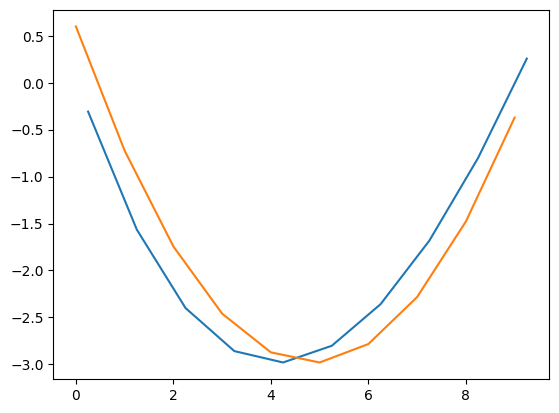

x_coeff:0.04952528447552257
y_coeff:52691.54163868352
z_coeff:2.02720888458915
49525.28447552257
52691.54163868352
28.491793418220198
-10000000.0
Vx: 31.838645628835536
Vy: 29.867051165918898


,RF
C,1.911068e-07
Ey,-9.024786e-08
Ez,2.047843e-08
Ex,7.312332e-06
U3=xy,-3.092507e-04
U4=yz,7.670937e-05
U2=z^2-(x^2+y^2)/2,-1.581793e-02
U5=zx,1.026775e-04
U1=x^2-y^2,1.418584e-04


In [ ]:

trap['electrodes']['RF']['potential'][:,:,0]*voltage**2*q/(4*m*Omega**2)/l**2*1000
print(np.shape(s.electrode_potential_roi['RF']))

q = 1.6*1e-19
l = 1e-3
m = 40*1.66054e-27
Omega = 2*np.pi*39.15*1e6
voltage = 1
#applying 80V p-p, contour in meV
etoV = voltage**2*q/(4*m*Omega**2)/l**2

potential = etoV*s.electrode_potential_roi['RF']
multipoles, potential_regenerated=\
s.expand_potentials_spherHarm({'RF':etoV*s.electrode_potential_roi['RF']},s.origin,s.X_roi,s.Y_roi,s.Z_roi,2, ['C','Ey','Ez', 'Ex', 'U3=xy', 'U4=yz', 'U2=z^2-(x^2+y^2)/2',
                                            'U5=zx', 'U1=x^2-y^2'])
u1 = multipoles['RF']['U1=x^2-y^2']
u2 = multipoles['RF']['U2=z^2-(x^2+y^2)/2']

r0 = 1e-3

x_coeff = u1/(2*r0**2)-u2/(2*r0**2)
y_coeff = -u1/(2*r0**2)-u2/(2*r0**2)

print("x_coeff:"+str(x_coeff/10**6))

x_coeff = np.gradient(np.gradient(potential[:,2,2],1e-6),1e-6)[2]
y_coeff = np.gradient(np.gradient(potential[2,:,2],1e-6),1e-6)[2]
z_coeff = np.gradient(np.gradient(potential[2,2,:],1e-6),1e-6)[2]

print(coordinates[0][0])
# plt.plot(d[:,coordinates[1]])
plt.plot(np.arange(0,10,1)+0.25,d[coordinates[0][0],(coordinates[1][0]-4):(coordinates[1][0]+6)])
plt.plot(np.arange(0,10,1),d[(coordinates[0][0]-5):(coordinates[0][0]+5),coordinates[1][0]])
plt.show()
print("x_coeff:"+str(x_coeff/10**6))
print("y_coeff:"+str(y_coeff))
print("z_coeff:"+str(z_coeff))

x_freq_unit_pot = (2*x_coeff*q/m)**0.5*1/(2*np.pi*10**6)
y_freq_unit_pot = (2*y_coeff*q/m)**0.5*1/(2*np.pi*10**6)

print(x_coeff)
print(y_coeff)

x_freq_measured = 2.215
y_freq_measured = 2.125

# x_freq_measured = 1.73
# y_freq_measured =1.57

vx = (x_freq_measured/x_freq_unit_pot)

print(vx)
u2_DC = -20/(2*r0**2)
print(u2_DC)
vx = ((-2*q*u2_DC+m*(x_freq_measured*2*np.pi*10**6)**2)/(2*q*x_coeff))**0.5
vy = ((-2*q*u2_DC+m*(y_freq_measured*2*np.pi*10**6)**2)/(2*q*y_coeff))**0.5


print("Vx: "+str(vx))
print("Vy: "+str(vy))


multipoles

    # def expand_potentials_spherHarm(potential_roi, r0, X_roi, Y_roi, Z_roi, order, multipole_names):
    #     '''
    #     This function expands potentials, and drop shperical harmonics normalization factors.
    #     It renames multipoles
    #     up to 2nd order: multipole_names = ['C','Ey','Ez', 'Ex', 'U3=xy', 'U4=yz', r'U2=z^2-(x^2+y^2)/2',
    #                                         'U5=zx', r'U1=x^2-y^2']
    #                      normalization_factors = [np.sqrt(1/4/np.pi), np.sqrt(3/4/np.pi), np.sqrt(3/4/np.pi), 
    #                                               np.sqrt(3/4/np.pi), np.sqrt(15/4/np.pi), np.sqrt(15/4/np.pi), 
    #                                               np.sqrt(20/16/np.pi), np.sqrt(15/4/np.pi), np.sqrt(15/16/np.pi)]

## (3) compute desired voltage configuration and plot result
height list is a list of places to expand the field generated by each electrode

In [242]:
height_list = trap['Y'][np.arange(nROI,len(trap['Z'])-nROI)]
print(np.arange(nROI,len(trap['Z'])-nROI))
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl, height, zl]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

[3 4 5 6 7]
height_list: [0.073 0.074 0.075 0.076 0.077]


## Plotting Multipole Decomposition for electrodes
Plots the multipole decomposition of the field generated from putting 1V on each electrode vs height 

Height here currently refers to the axial location along the trap

['DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'DC9', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'DC17', 'DC18', 'DC19', 'DC20', 'DC21']


/Users/Ben/opt/anaconda3/envs/bemtest/lib/python3.9/site-packages/utils/plottingfuncns.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(s.controlled_elecs, rotation=45, fontsize=12)


<Figure size 640x480 with 0 Axes>

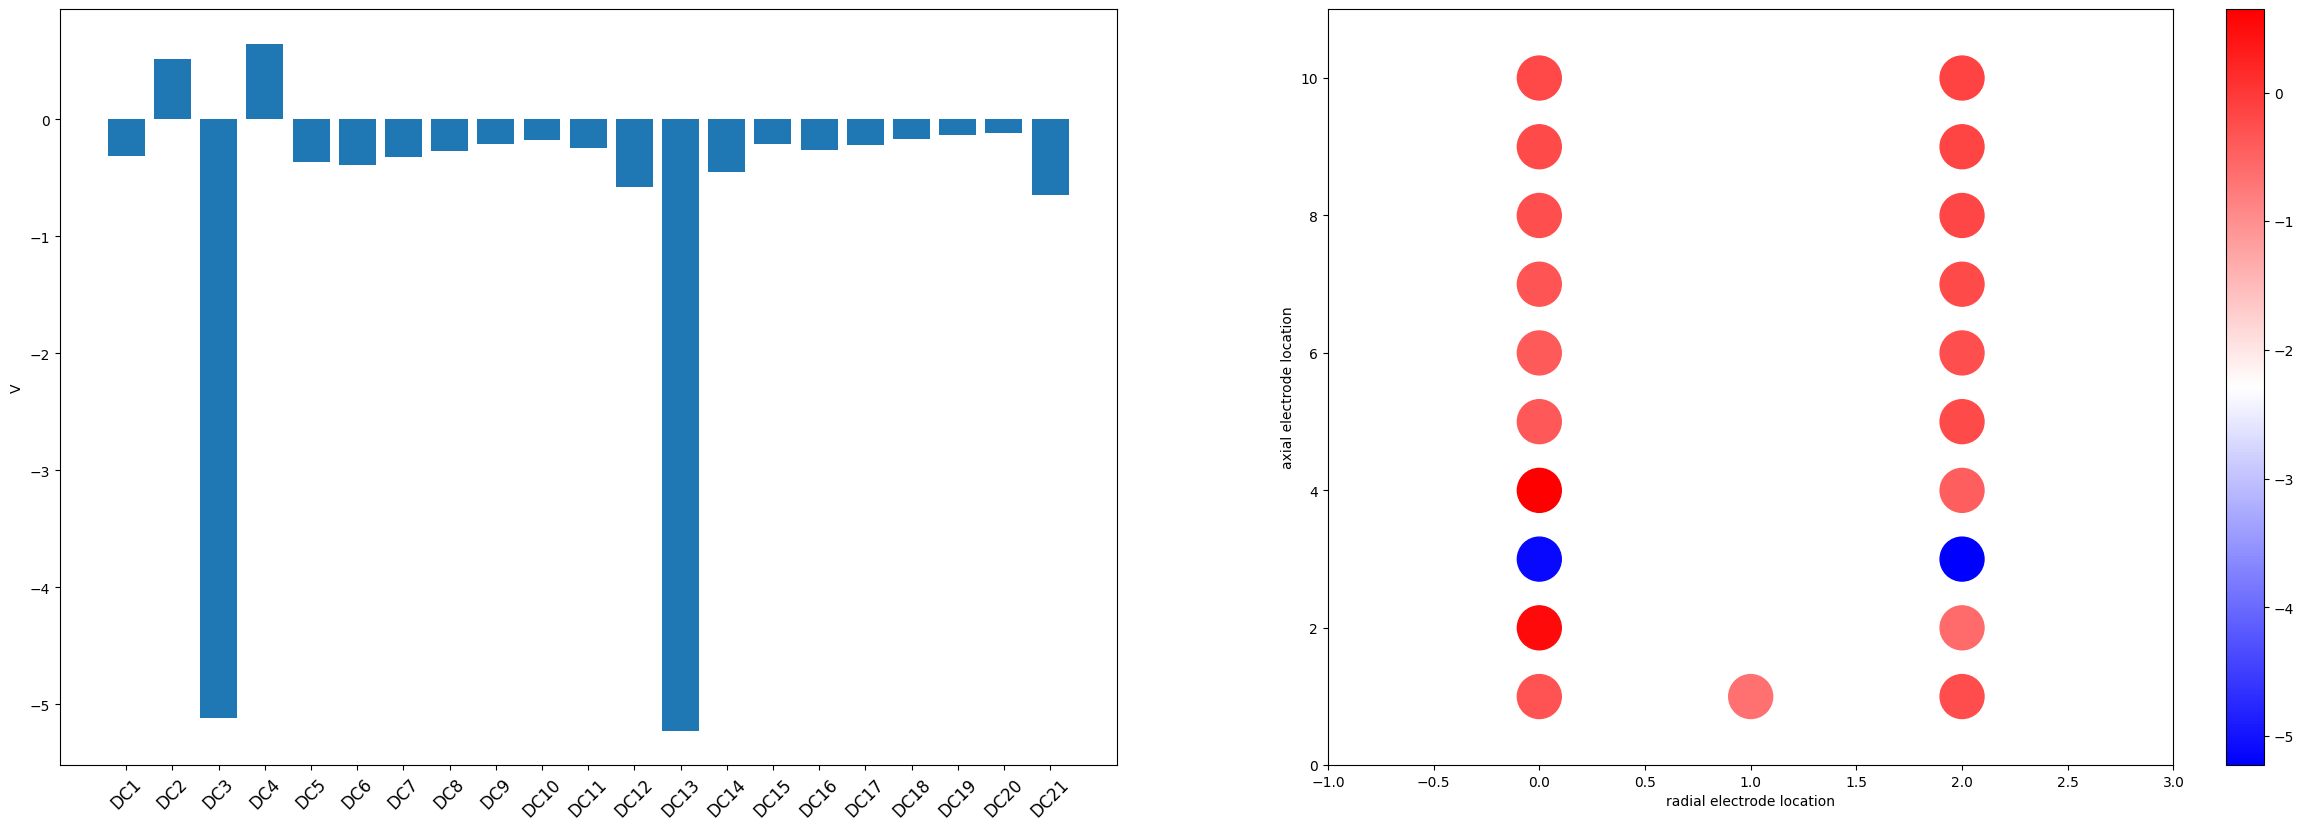

In [243]:
fig = plt.figure()
fig.canvas.draw()
fig.tight_layout(pad=1)
plot_muls(s,xl-0.5e-3,zl-2e-3,roi,height= 73, ez=0, ex=0, ey=0,u2=8, u5=0, u1=0, u3=0,u4=0)

## Generating Axial Confinment
Here are plots of asking for a pure U2 multiple, which generates confinement in the z-dir

DC1    -0.336087
DC2     0.344525
DC3    -2.667141
DC4     0.291455
DC5    -0.139859
DC6    -0.212192
DC7    -0.180212
DC8    -0.155656
DC9    -0.120259
DC10   -0.103535
DC11   -0.343610
DC12   -0.395945
DC13   -2.502103
DC14   -0.423148
DC15   -0.130846
DC16   -0.150618
DC17   -0.125658
DC18   -0.099433
DC19   -0.079039
DC20   -0.068459
DC21   -0.349880
dtype: float64


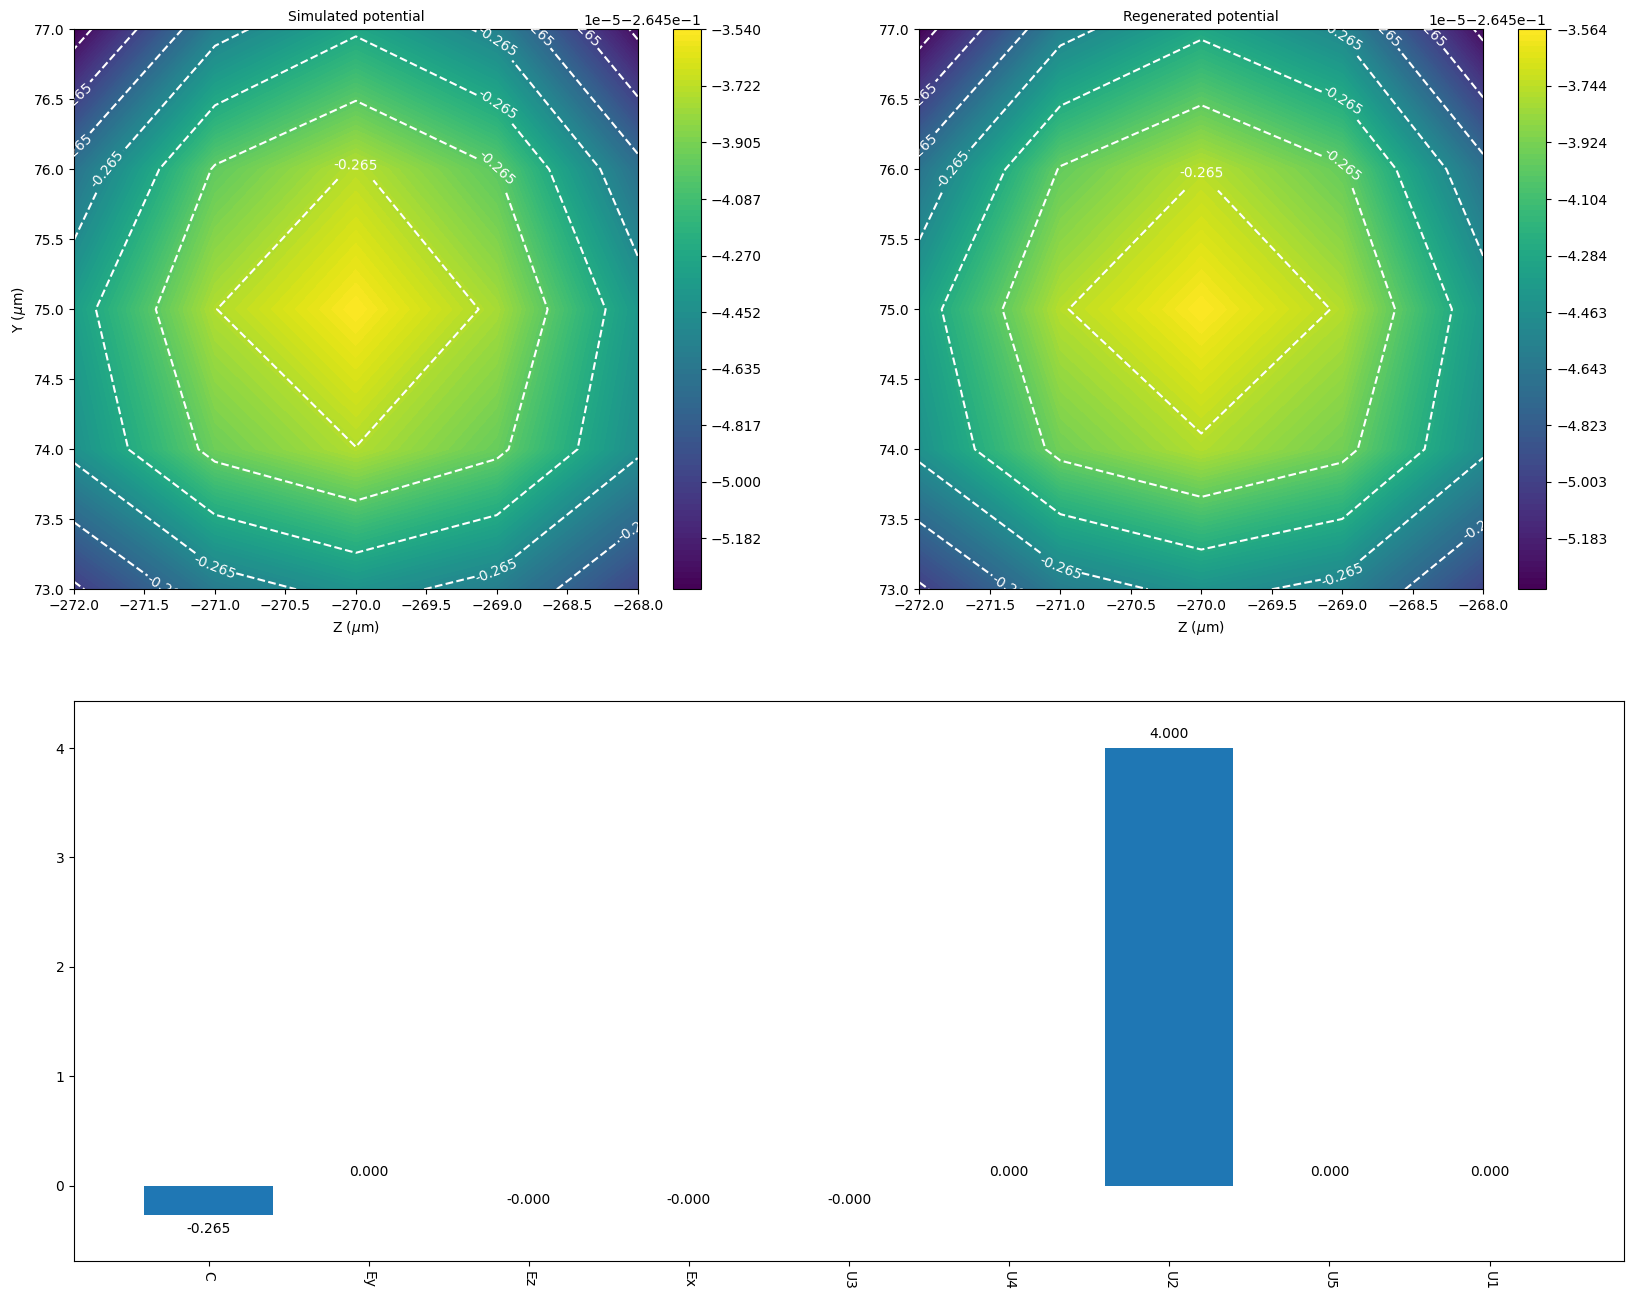

DC1    -0.672174
DC2     0.689051
DC3    -5.334281
DC4     0.582910
DC5    -0.279719
DC6    -0.424383
DC7    -0.360424
DC8    -0.311312
DC9    -0.240517
DC10   -0.207070
DC11   -0.687219
DC12   -0.791891
DC13   -5.004207
DC14   -0.846295
DC15   -0.261691
DC16   -0.301235
DC17   -0.251316
DC18   -0.198866
DC19   -0.158078
DC20   -0.136918
DC21   -0.699761
dtype: float64
2
(5, 5, 5)


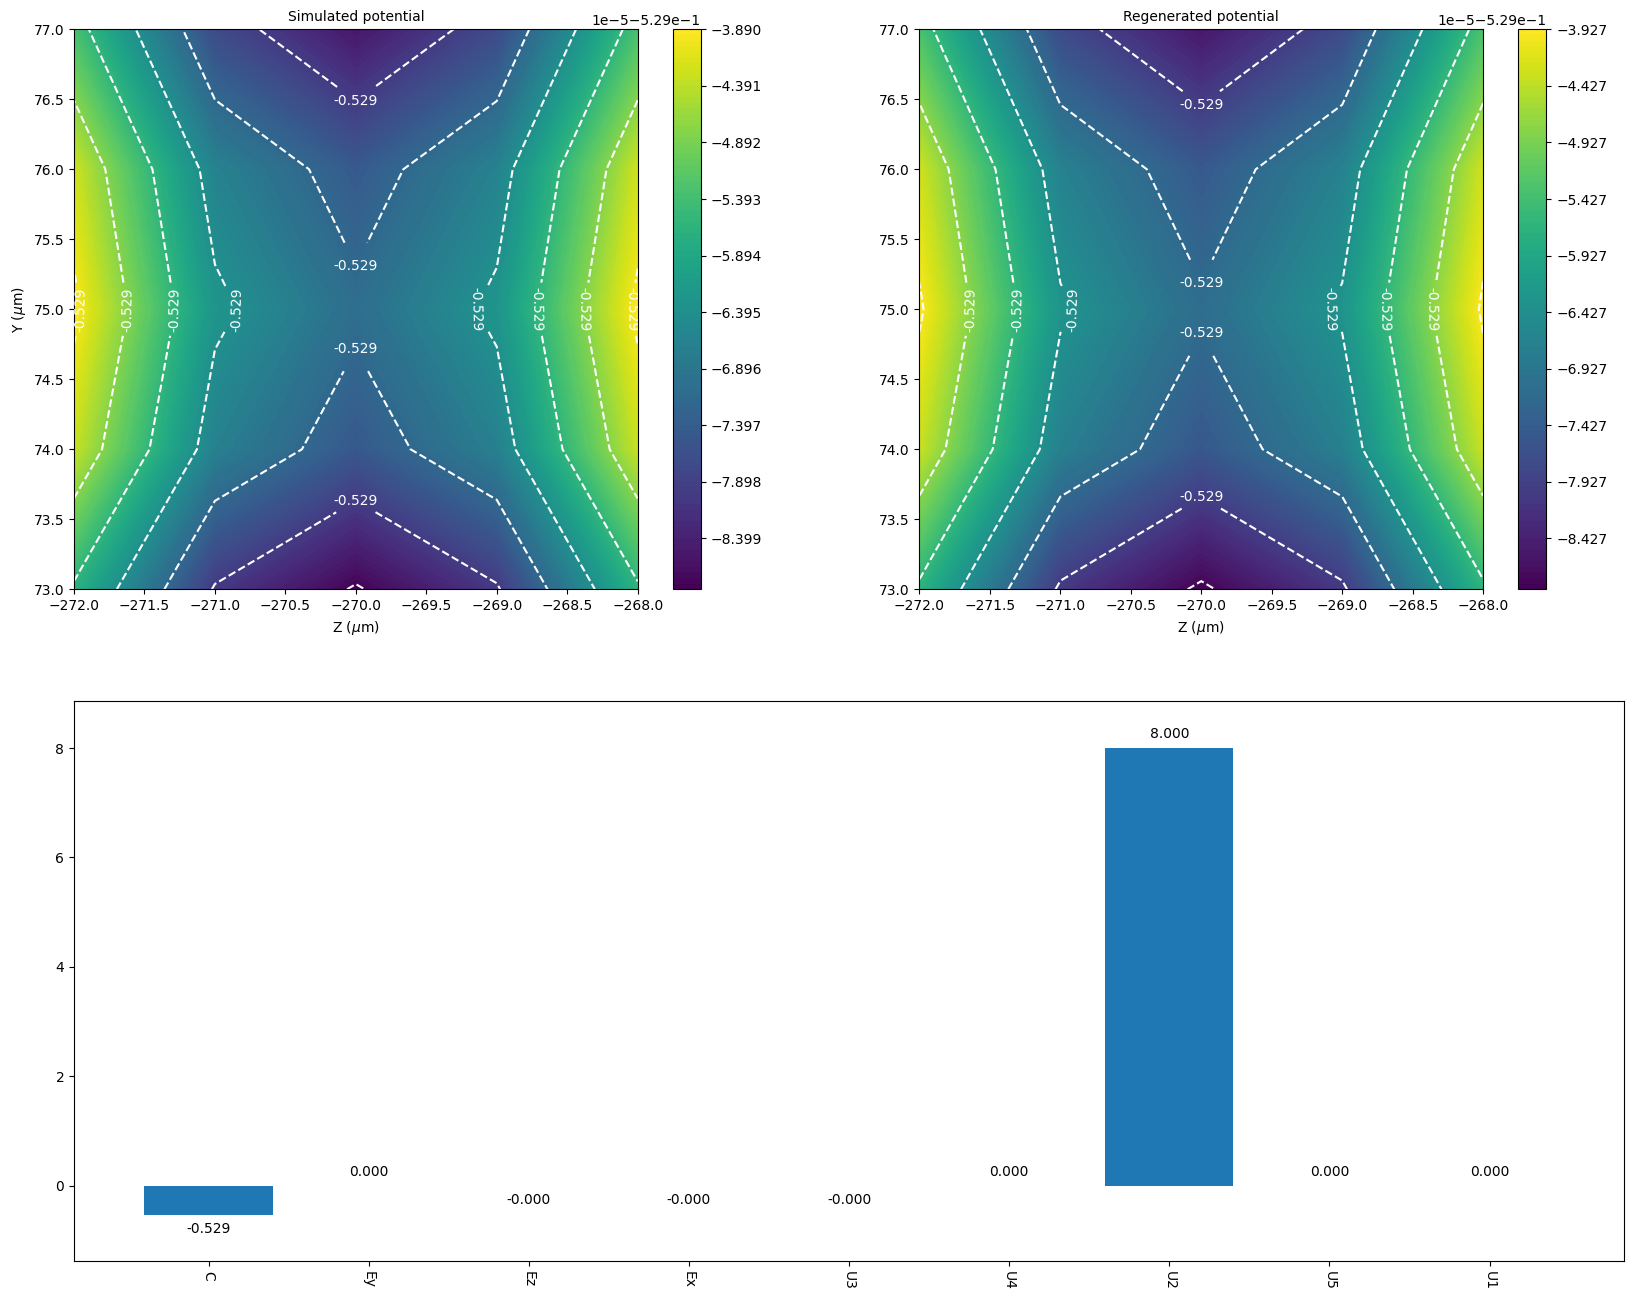

In [215]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
u4 = 0
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
def plot_U21(s,xl,zl,roi,height, ey, ez, ex, u3, u2, u5, u1,view='zy'):
    position1 = [xl, height * 1e-3, zl]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {'Ey': ey, 'Ez': ez, 'Ex': ex
    , 'U3': u3, 'U2': u2, 'U5': u5, 'U1': u1,'U4':u4}
    voltages = s.setMultipoles(multipole_coeffs)
    print(voltages)
    potential_roi = s.potentialControl_roi(voltages)
    potential_regen = s.potentialControl_regen(voltages)
    # nearestZ = find_nearest(s.Z, height * 1e-3)
    # indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
    fsize = 10
    fig1 = plt.figure(figsize=(20, 16))
    if view == 'zy':
        nearestX = find_nearest(s.X, xl)
        indNearestX_roi = np.abs(s.X_roi - nearestX).argmin()
        print(indNearestX_roi)
        print(np.shape(potential_roi))
        potential_xy_roi = potential_roi[indNearestX_roi]
        potential_xy_regen = potential_regen[indNearestX_roi]
        fig.suptitle('Z-Y Plane',fontsize=20)
    else:
        nearestZ = find_nearest(s.Z, zl)
        indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
        potential_xy_roi = potential_roi[:,:,indNearestZ_roi]
        potential_xy_regen = potential_regen[:,:,indNearestZ_roi]
        potential_xy_regen = np.transpose(potential_xy_regen)
        potential_xy_roi = np.transpose(potential_xy_roi)
        fig.suptitle('X-Y Plane',fontsize=20)
    grid = plt.GridSpec(2, 2)
    ax1 = fig1.add_subplot(grid[0, 0])
    ax2 = fig1.add_subplot(grid[0, 1])
    ax3 = fig1.add_subplot(grid[1, :])
    ax1.set_title('Simulated potential', fontsize=fsize)
    levels1 = np.linspace(np.amin(potential_xy_roi), np.amax(potential_xy_roi), 100)
    plot1 = ax1.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, levels1, cmap=plt.cm.viridis)
    plot1_line = ax1.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, colors='w')
    #     ax1.clabel(plot1_line, inline = 1, fontsize = fsize)
    ax1.clabel(plot1_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax1.set_xlabel('Z ($\mu$m)', fontsize=fsize)
    ax1.set_ylabel('Y ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot1, ax=ax1)

    ax2.set_title('Regenerated potential', fontsize=fsize)
    levels2 = np.linspace(np.amin(potential_xy_regen), np.amax(potential_xy_regen), 100)
    plot2 = ax2.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, levels2, cmap=plt.cm.viridis)
    plot2_line = ax2.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, colors='w')
    #     ax2.clabel(plot2, inline = 1, fontsize = fsize)
    ax2.clabel(plot2_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax2.set_xlabel('Z ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot2, ax=ax2)
    coeffs = s.setVoltages(voltages)
    ax3.bar(np.arange(9), np.asarray(coeffs)[0:9])
    max_coeff = np.max(coeffs[0:9])
    min_coeff = np.min(coeffs[0:9])
    margin = (max_coeff - min_coeff) * 0.1
    ymax = max_coeff + margin
    ymin = min_coeff - margin
    ax3.set_ylim(ymin, ymax)
    add_value_labels(ax3)
    ax3.set_xticks(np.arange(9))
    ax3.set_xticklabels(s.multipole_names, rotation=-90, fontsize=fsize)
    plt.show()
plot_U21(s,xl,zl,roi,height=75.00, ez=0, ex=0, ey=0, u2=4, u5=0, u1=0, u3=0,view = 'xy')

plot_U21(s,xl,zl,roi,height=75.00, ez=0, ex=0, ey=0, u2=8, u5=0, u1=0, u3=0,view = 'zy')
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=1, ey=0, u2=0, u5=0, u1=0, u3=0,u4=0,view = 'xy')
# output = interactive_plot.children[-1]
# output.layo

## Plotting Spherical Harmonic  Decomposition
This plots the spherical harmonic decomposition up to 2nd-order of the multipoles of the fields generated by placing 1V on an electrode specified in electrode_list and ground all others.

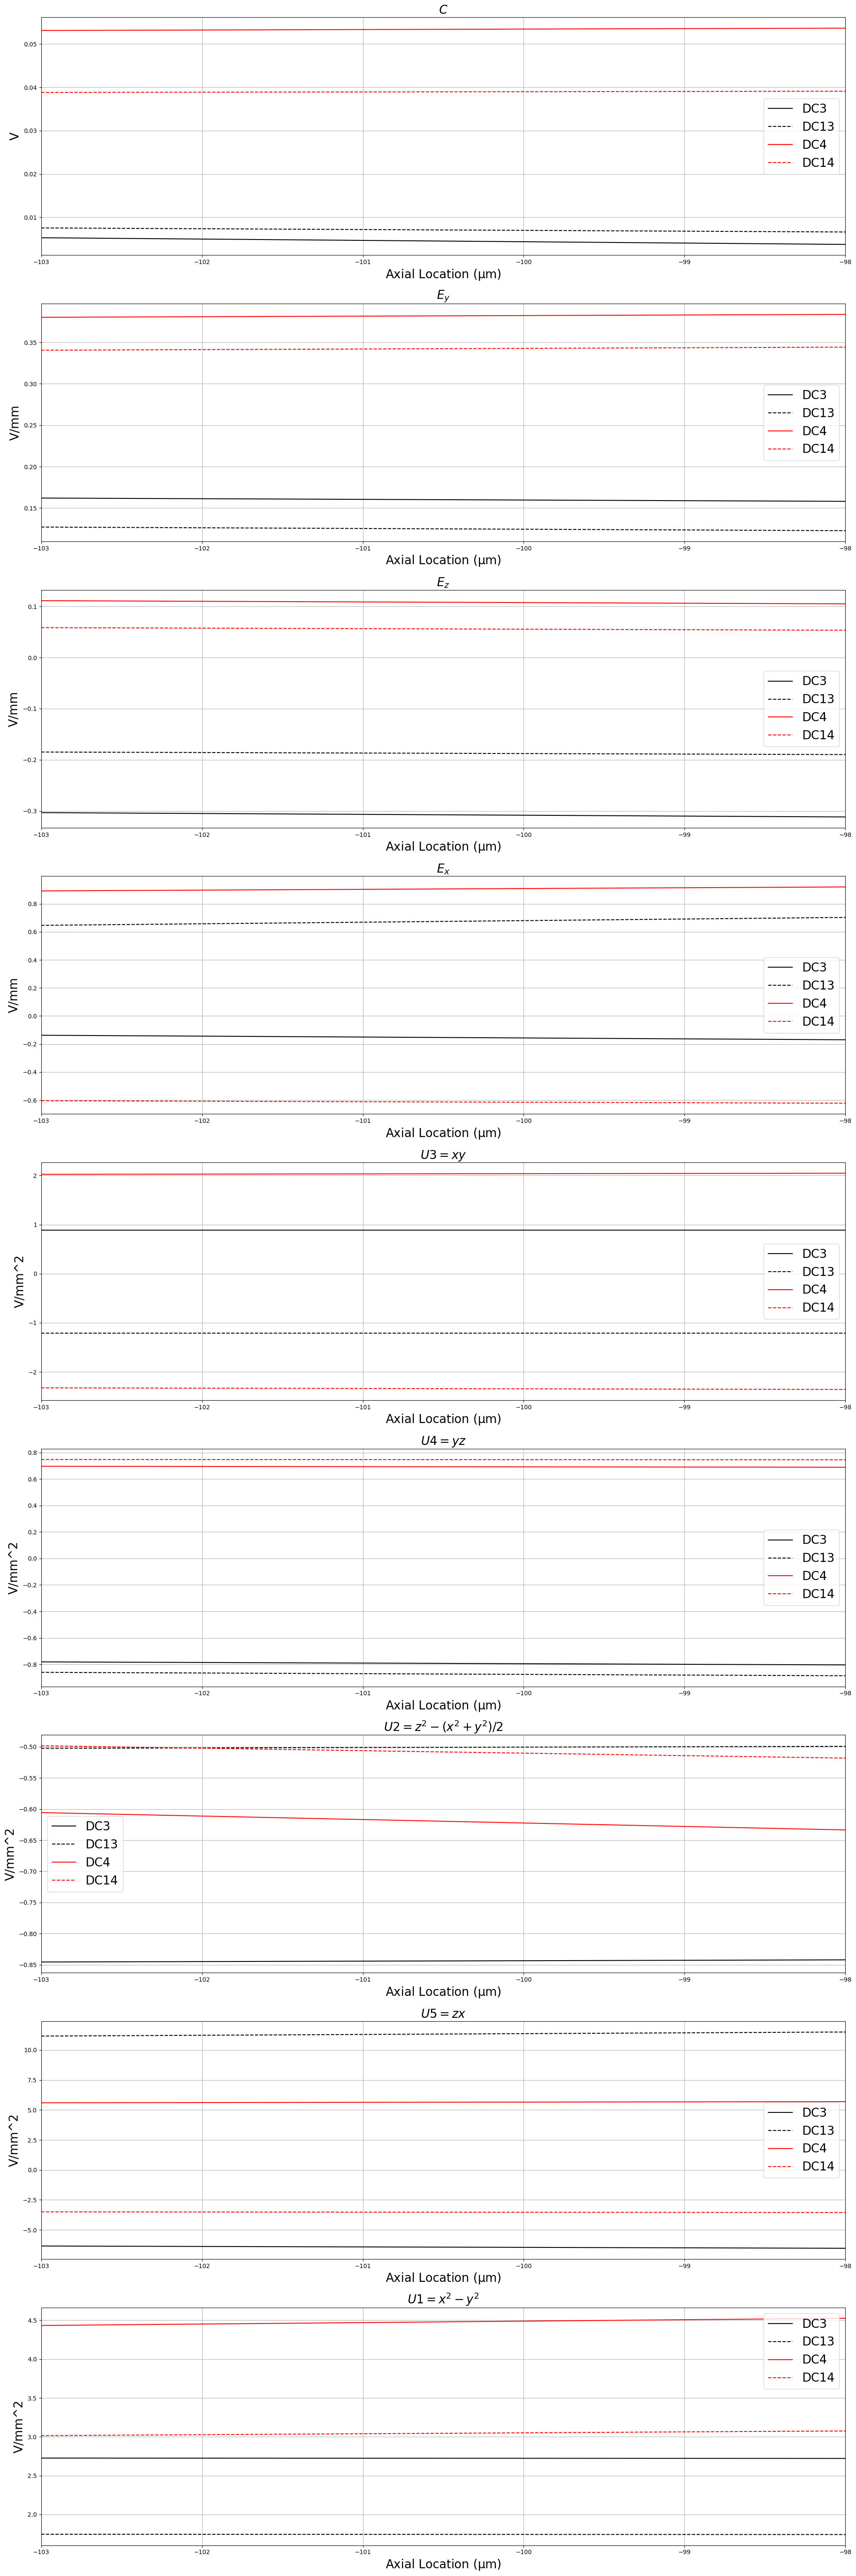

In [216]:
# 'height list' is the list of the places to do the spherical decomp. of the electrode potential
# if you use too many points it will take a while to generate the plot
print()
height_list = np.arange(-103e-3,-97e-3,1e-3)
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
for i, height in enumerate(height_list):
    position1 = [xl, yl,height]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

size = 20
electrode_list = ['DC3','DC13','DC4','DC14']
# electrode_list = ['DC21']

fig, ax = plt.subplots(numMUltipoles, 1, figsize=(20, 60))
for i, mul in enumerate(s.multipole_print_names):
    ax[i].set_prop_cycle(linestyle = ['-','--','-','--','-','--','--','--','--','--'],color= ['black','black','red','red','orange','black','blue','purple','red','orange'])
    for ele in electrode_list:
        j = s.electrode_names.index(ele)
        ax[i].plot(height_list*1e3, multipoles_vs_height[:, i, j], label=ele)
        if i == 0:
            ax[i].set_ylabel('V',fontsize=size)
        elif i < 4:
            ax[i].set_ylabel('V/mm',fontsize=size)
        else:
            ax[i].set_ylabel('V/mm^2',fontsize=size)
        ax[i].set_title(mul, fontsize=size)
        ax[i].set_xticks(np.arange(-300,300,1))
        ax[i].set_xlabel(r'Axial Location ($\mathrm{\mu}$m)', fontsize=size)
        ax[i].set_xlim(min(height_list*1e3),max(height_list*1e3))
        ax[i].grid(visible=True)
        ax[i].legend(fontsize=size)
    fig.tight_layout()

In [ ]:
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 30 volts
# %%
numMUltipoles = len(used_multipoles)
Coeffs = pd.DataFrame()
for height in height_list:
    position1 = [xl, yl,height*1e-3]
    s.update_origin_roi(position1, roi)

    Coeffs_temp = pd.Series(dtype=float)
    for key in used_multipoles:
        multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
        multipole_coeffs[key] = 1
        voltages = s.setMultipoles(multipole_coeffs)
        max_v = np.max(abs(voltages))
        Coeffs_temp[key] = 30 / max_v

    Coeffs[height] = Coeffs_temp

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels

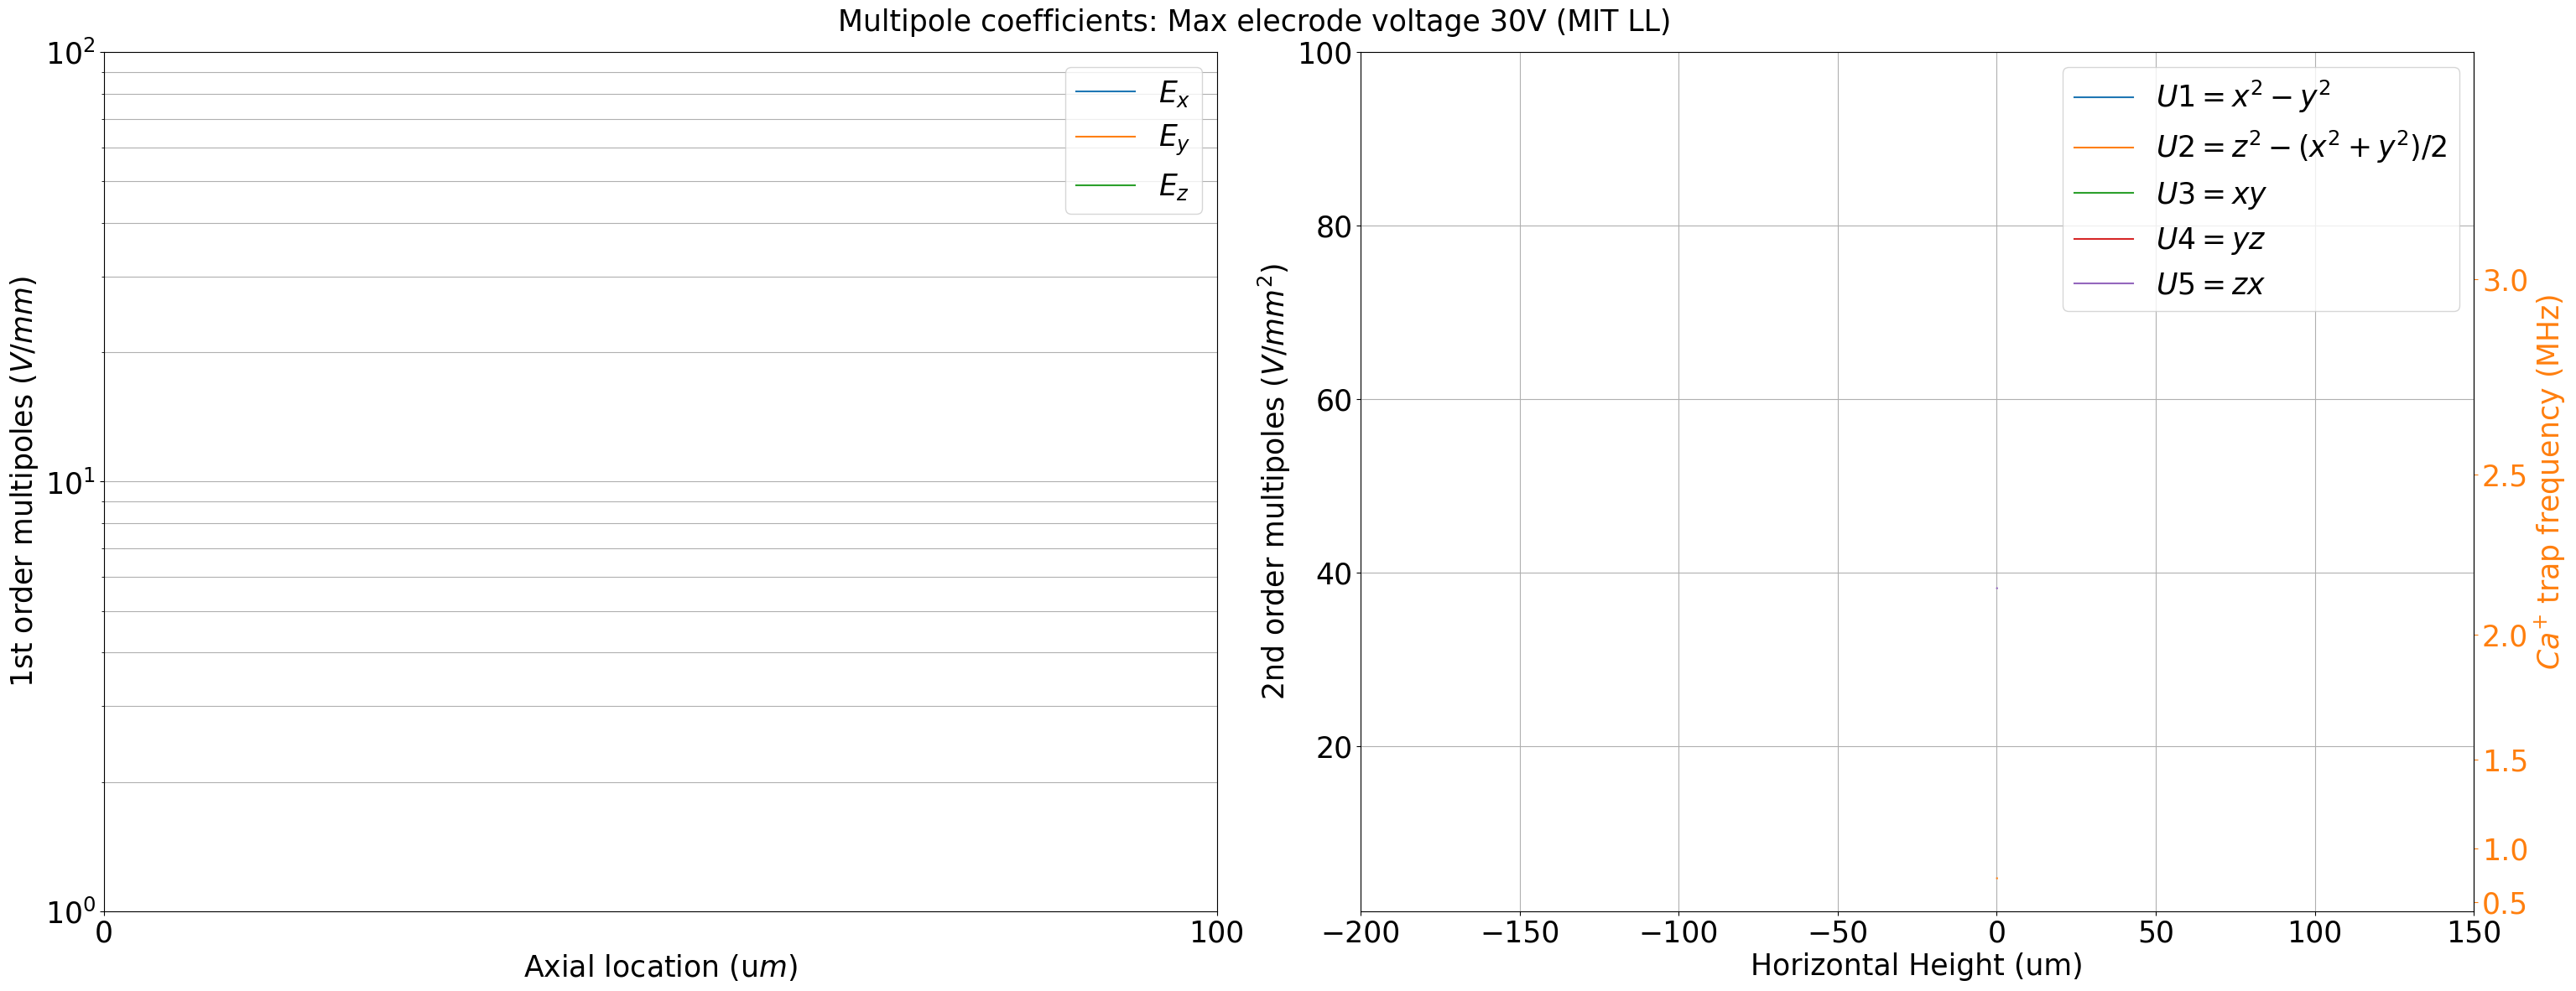

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
 

for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_yscale('log')
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(np.arange(00, 200, 100))
ax1.set_xlabel(r'Axial location ($\mathrm{u}m$)', fontsize=size)
ax2.set_xlabel('Vertical Height ($\mathrm{u}m$)', fontsize=size)
ax1.tick_params(labelsize=size,which='minor')
ax1.legend(fontsize=size)
ax1.set_ylim(1, 100)  # set ylim


ax1.grid(which='both')

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(np.arange(-200, 200, 50))
ax2.set_xlabel('Axial Location (um)', fontsize=size)
ax2.set_xlabel('Horizontal Height (um)', fontsize=size)

ax2.set_ylim(1, 1e2)  # set ylim
# ax2.set_yscale('log')
# ax2.set_tick_params(axis='y', which='minor')
ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(which='both')
fig.suptitle('Multipole coefficients: Max elecrode voltage 30V (MIT LL)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')

# plt.savefig('Multipole_coeffs_20v_rfbias.jpg', format = 'jpg', dpi = 300) 

# plot_1d(s,xl,zl,roi,height=75, ez=0, ex=0, ey=0, u2=10,u5=0, u1=0, u3=0)
# %%
outarray = []

# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
# output = interactive_plot.children[-1]
# output.layout.height = '1000px'

/Users/Ben/opt/anaconda3/envs/bemtest/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/Ben/opt/anaconda3/envs/bemtest/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/Ben/opt/anaconda3/envs/bemtest/lib/python

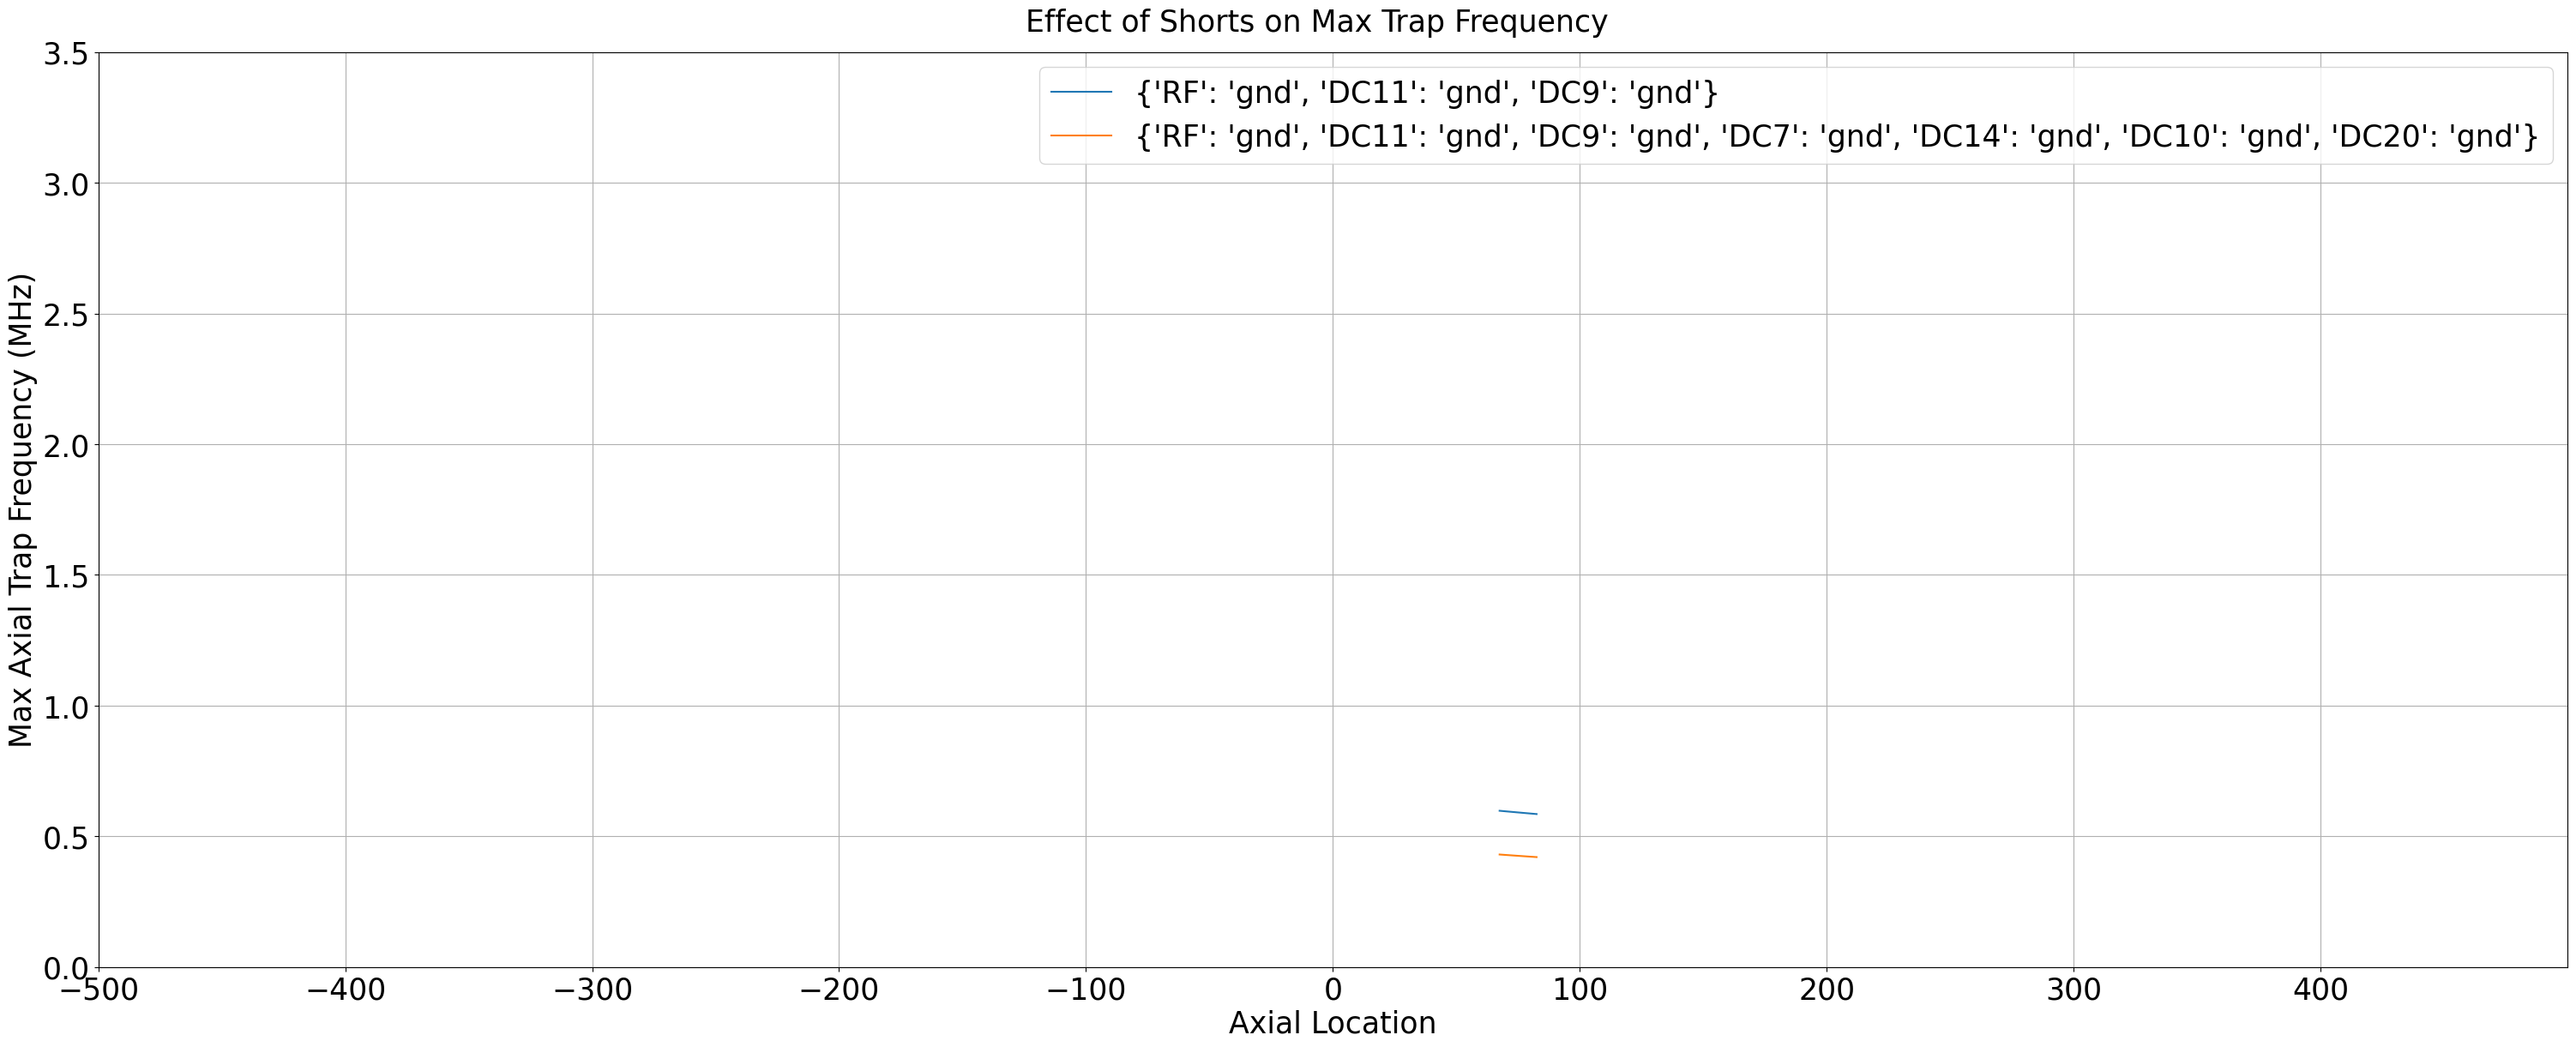

In [ ]:
def build_electrode_config(all_electrodes, exclusions):
    #build the controlled electrodes list, given the constraints of the 'exclusion' list
    #controlled electrodes- this will define which electrodes will be used to control your trap
    controlled_electrodes = []
    for electrode in strs:
        if electrode in exclusions and exclusions[electrode] != "gnd":
            trap['electrodes'][exclusions[electrode]]["potential"] = trap['electrodes'][exclusions[electrode]]["potential"] + \
                                                            trap['electrodes'][electrode]["potential"]
        elif electrode not in exclusions:
            controlled_electrodes.append(electrode)
    return controlled_electrodes

def plot_control_config(exclusion_list,ax2):
    controlled_electrodes = build_electrode_config(strs,exclusion_list)
    # create MultipoleControl object
    s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)

    Coeffs = pd.DataFrame()
    for height in height_list:
        position1 = [xl, yl,height]
        s.update_origin_roi(position1, roi)
        Coeffs_temp = pd.Series(dtype=float)
        for key in used_multipoles:
            multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
            multipole_coeffs[key] = 1
            voltages = s.setMultipoles(multipole_coeffs)
            max_v = np.max(abs(voltages))
            Coeffs_temp[key] = 30 / max_v
        Coeffs[height] = Coeffs_temp

    ax2.plot(height_list*1e3, U2_to_mhz(Coeffs.loc['U2']), label=exclusion_list)
    ax2.set_ylabel(r'Max Axial Trap Frequency (MHz)', fontsize=size)
    ax2.set_xticks(np.arange(-500, 500, 100))
    ax2.set_xlabel(r'Axial Location', fontsize=size)

    ax2.set_ylim(0,3.5)  # set ylim
    ax2.set_xlim(-500,500)
    ax2.tick_params(labelsize=size)
    ax2.legend(fontsize=size)
    ax2.grid(which='both')
excl0 = {
    "RF":"gnd",
    "DC11":"gnd",
    "DC9":"gnd",
    # "DC10":"gnd",
    # "DC20":"gnd",
}
excl1 = {
    "RF":"gnd",
    "DC11":"gnd",
    "DC9":"gnd",
    "DC7":"gnd",
    "DC14":"gnd",
    'DC10':"gnd",
    "DC20":"gnd"
}
#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
size = 25
numMUltipoles = len(used_multipoles)
fig, ax2 = plt.subplots(1, 1, figsize=(30, 12))
ax2.grid()
fig.suptitle('Effect of Shorts on Max Trap Frequency', fontsize=size)
fig.tight_layout(pad=1)
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plot_control_config(excl0,ax2)
plot_control_config(excl1,ax2)
plt.show()

Text(0, 0.5, '$Ca^{+}$ trap frequency (MHz)')

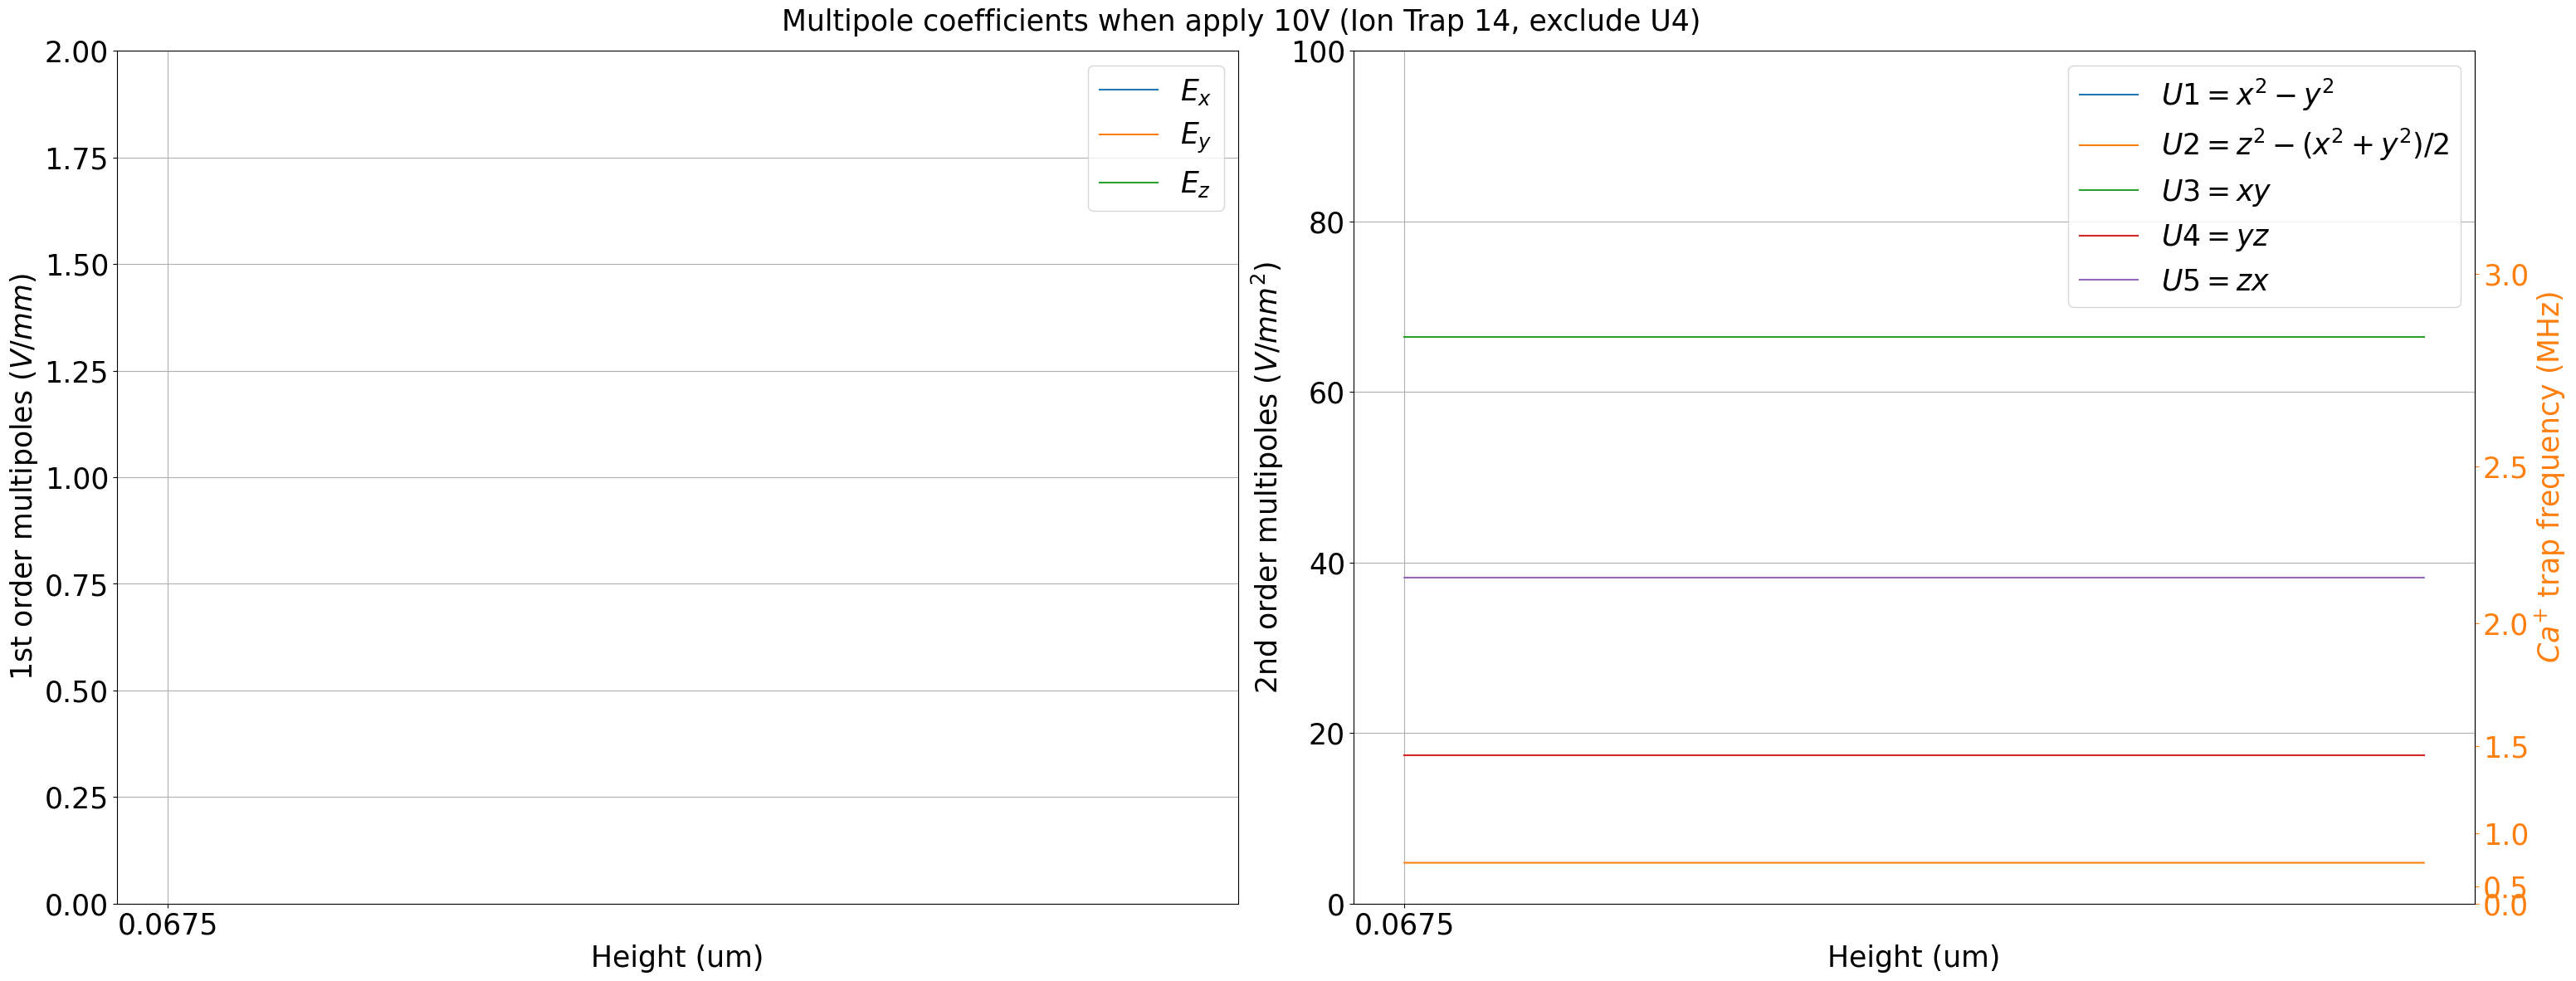

In [ ]:
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 40 volts
# %%
excl = {
    # "DC6": "gnd",
    #     "DC4": "gnd",
        # "DC5": "gnd",
    #     "DC8": "gnd",
    #     "DC14": "DC13",
        # "DC11": "gnd",
        # "DC12": "gnd",
#     "DC1": "gnd",
#     "DC19": "gnd",
    "RF":"gnd"
}
numMUltipoles = len(used_multipoles)

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))


for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax1.set_xlabel('Height (um)', fontsize=size)
ax1.tick_params(labelsize=size)
ax1.legend(fontsize=size)

ax1.set_ylim(0, 2)  # set ylim

ax1.grid(True)

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax2.set_xlabel('Height (um)', fontsize=size)

ax2.set_ylim(0, 100)  # set ylim


ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(True)
fig.suptitle('Multipole coefficients when apply 10V (Ion Trap 14, exclude U4)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')